# Chatbot with Memory

## Review

[Memory](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/) is a cognitive function that allows people to store, retrieve, and use information to understand their present and future. 

There are [various long-term memory types](https://docs.langchain.com/oss/python/concepts/memory#memory-types) that can be used in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.
 
We'll focus on long-term [semantic memory](https://docs.langchain.com/oss/python/concepts/memory#semantic-memory), which will be facts about the user. 

These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

It will save memory ["in the hot path"](https://docs.langchain.com/oss/python/concepts/memory#writing-memories), as the user is chatting with it.

In [27]:
import uuid
from langchain_openai import ChatOpenAI
from langchain_groq import  ChatGroq
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.store.memory import InMemoryStore
from IPython.display import display, Markdown
import uuid

In [3]:
store = InMemoryStore()

## Introduction to the LangGraph Store

The  [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.com/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

When storing objects (e.g., memories) in the [Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [5]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
print(key)

073f5d90-88ce-420d-9d86-0e212450acea


In [30]:
# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza", "name": "Umer", "age": 20}


store.put(namespace=namespace_for_memory, key=key, value=value)

In [31]:
store.list_namespaces()

[('1', 'memories')]

We use [search](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.search) to retrieve objects from the store by `namespace`.

This returns a list.

In [32]:
# Search for items within a namespace prefix.
memories = store.search(namespace_for_memory)
type(memories)

list

In [33]:
memories

[Item(namespace=['1', 'memories'], key='073f5d90-88ce-420d-9d86-0e212450acea', value={'food_preference': 'I like pizza', 'name': 'Umer', 'age': 20}, created_at='2026-01-05T13:28:40.971167+00:00', updated_at='2026-01-05T13:28:40.971167+00:00', score=None)]

In [34]:
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '073f5d90-88ce-420d-9d86-0e212450acea',
 'value': {'food_preference': 'I like pizza', 'name': 'Umer', 'age': 20},
 'created_at': '2026-01-05T13:28:40.971167+00:00',
 'updated_at': '2026-01-05T13:28:40.971167+00:00',
 'score': None}

In [35]:
# key, value
Markdown(f"**Key:** {memories[0].key} **Memory:** {memories[0].value}**")

**Key:** 073f5d90-88ce-420d-9d86-0e212450acea **Memory:** {'food_preference': 'I like pizza', 'name': 'Umer', 'age': 20}**

In [48]:
# Get the memory by namespace and key
memory = store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '073f5d90-88ce-420d-9d86-0e212450acea',
 'value': {'food_preference': 'I like pizza', 'name': 'Umer', 'age': 20},
 'created_at': '2026-01-05T13:28:40.971167+00:00',
 'updated_at': '2026-01-05T13:28:40.971167+00:00'}

In [53]:
memory.value

{'food_preference': 'I like pizza', 'name': 'Umer', 'age': 20}

We can also use [get](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

## Chatbot with long-term memory

We want a chatbot that [has two types of memory](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156):

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

For `short-term memory`, we'll use a [checkpointer](https://docs.langchain.com/oss/python/langgraph/persistence#checkpointer-libraries). 

See Module 2 and our [conceptual docs](https://docs.langchain.com/oss/python/langgraph/persistence) for more on checkpointers, but in summary:

* They write the graph state at each step to a thread.
* They persist the chat history in the thread.
* They allow the graph to be interrupted and / or resumed from any step in the thread.
 
And, for `long-term memory`, we'll use the [LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) as introduced above.

In [37]:
model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
model.invoke("hello").content

'Hello! How can I assist you today?'

The chat history will be saved to short-term memory using the checkpointer.

The chatbot will reflect on the chat history. 

It will then create and save a memory to the [LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore).

This memory is accessible in future chat sessions to personalize the chatbot's responses.

In [38]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """
    You are a helpful assistant with memory that provides information about the user. 
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {memory}
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"
    You are collecting information about the user to personalize your responses.

    CURRENT USER INFORMATION: {memory}

    INSTRUCTIONS:
        1. Review the chat history below carefully
        2. Identify new information about the user, such as:
            - Personal details (name, location)
            - Preferences (likes, dislikes)
            - Interests and hobbies
            - Past experiences
            - Goals or future plans
        3. Merge any new information with existing memory
        4. Format the memory as a clear, bulleted list
        5. If new information conflicts with existing memory, keep the most recent version

    Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

    Based on the chat history below, please update the user information:
"""

In [54]:
def chatModel(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # get the user ID from the store
    user_id = config["configurable"]["user_id"]

    # retreive memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # extract the memory
    if existing_memory:
        # value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found."

    # format the memory in the system prompt
    system_msg = SystemMessage(content=MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content))

    # respond using memory as well as the chat history
    response = model.invoke([system_msg] + state["messages"])

    return {"messages": response}

In [55]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Create new memory from the chat history and any existing memory, then save it to the store."""

    # get the user ID from the store
    user_id = config["configurable"]["user_id"]

    # retreive memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = SystemMessage(content=CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content))
    new_memory = model.invoke([system_msg] + state["messages"])

    # Overwrite the existing memory in the store
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})


In [56]:
# Define the graph
graph_builder = StateGraph(MessagesState)

# Add graph nodes
graph_builder.add_node("chatModel", chatModel)
graph_builder.add_node("write_memory", write_memory)

# Define the graph edges
graph_builder.add_edge(START, "chatModel")
graph_builder.add_edge("chatModel", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Build the graph
graph = graph_builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

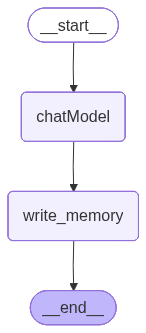

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice. 

In [58]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = { "configurable": { "thread_id" : "1", "user_id" : "1" } }

# user input
input_messages = [HumanMessage(content="Hi, I'm Umer. I love hiking and wandering.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I'm Umer. I love hiking and wandering.
================================== Ai Message ==================================

Hi Umer! It's great to meet someone who loves hiking and wandering. Do you have any favorite trails or places you'd like to explore next?


In [60]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")

existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '- Name: Umer\n- Interests and hobbies: Hiking and wandering'},
 'created_at': '2026-01-05T14:18:39.015620+00:00',
 'updated_at': '2026-01-05T14:18:39.015620+00:00'}

In [61]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Umer! Since you enjoy hiking and wandering, you might also enjoy exploring scenic biking trails. Depending on your location, I can recommend some great spots. If you're looking for general ideas, national parks, mountain trails, or coastal paths often offer fantastic biking experiences. Let me know where you're located or if you have a specific type of scenery you prefer, and I can give you more tailored suggestions!
